In [153]:
import numpy as np

In [154]:
class ScratchKMeans():
    """
    K-means scratch implementation
    Parameters
    ----------
    n_clusters : int
      Number of clusters
    n_init : int
      How many times to change the initial value of the center point for calculation
    max_iter : int
      Maximum number of iterations in one calculation
    tol : float
      Margin of error between the center point and the center of gravity, which is the reference for ending the iteration
    verbose : bool
      True to output the learning process
    """

    def __init__(self, n_clusters=8, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        # Record hyperparameters as attributes
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _init_mu_k(self, X):
        rows = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        return X[rows, :]

    def _compute_SSE(self, X, mu, r):
        '''
        Calculate SSE
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
          Features of training data
        r : shape (n_samples, self.n_clusters)
          cluster assignment
        mu : shape (self.n_clusters, n_features)
          center points
        Return
        ----------
        SSE: shape (n_features, )
          SSE
        '''
        SSE = 0.0
        for k in range(0, self.n_clusters):
            SSE += r[:, k] @ np.linalg.norm(X - mu[k, :], axis=1)**2
        return SSE
    
    def _allocate_r(self, X, mu):
        """
        Allocate data points X to the nearest center point.
        """
        distance_matrix = np.zeros((X.shape[0], self.n_clusters))
        for k in range(0, self.n_clusters):
            distance_matrix[:, k] = np.linalg.norm(X - mu[k, :], axis=1)
        r = np.zeros((X.shape[0], self.n_clusters))
        r[np.arange(len(r)), np.argmin(distance_matrix, axis=1)] = 1
        return r

    def _move_mu(self, X, r):
        """
        Moves mu to the mean (center of gravity)
        """
        mu = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(0, self.n_clusters):
            mu[k, :] = X[r[:, k] == 1].mean(axis=0)
        return mu

    def _learning(self, X, init_mu):
        mu = init_mu
        r = self._allocate_r(X, mu)
        prev_mu = mu
        i = 0
        while (i < self.max_iter):
            mu = self._move_mu(X, r)
            r = self._allocate_r(X, mu)
            if (self.tol != None):
                if (abs(np.sum(mu - prev_mu)) <= self.tol):
                    break
            prev_mu = mu
            i+=1
        return mu, r

    def _find_best_learnings(self, X):
        SSE_list = []
        mu_list = []
        r_list = []
        for i in range(0, self.n_init):
            mu, r = self._learning(X, self._init_mu_k(X))
            SSE_list.append(self._compute_SSE(X, mu, r))
            mu_list.append(mu)
            r_list.append(r)
            if self.verbose:
                print("iter: {}   SSE: {}".format(i, SSE_list[-1]))
        min_idx = np.argmin(np.array(SSE_list))
        return SSE_list[min_idx], mu_list[min_idx], r_list[min_idx]

    def fit(self, X):
        """
        Calculate clustering by K-means
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        """
        if self.verbose:
            print("learning...")
            self.SSE, self.mu, self.r = self._find_best_learnings(X)
        else:
            self.SSE, self.mu, self.r = self._find_best_learnings(X)

    def predict(self, X):
        """
        Calculate which cluster the input data belongs to
        """
        return np.where(self._allocate_r(X, self.mu) == 1)[1]

<h3>Dataset</h3>

In [155]:
from sklearn.datasets import make_blobs
X, correct_labels = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

Text(0.5, 1.0, 'Blobs, centers = 4, features = 2, samples = 100')

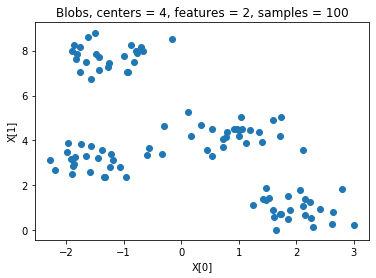

In [156]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.title("Blobs, centers = 4, features = 2, samples = 100")

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.25, random_state=0)

<h4>Scratch training</h4>

In [158]:
kmeans_scratch = ScratchKMeans(n_clusters=8)
kmeans_scratch.fit(X_train)
kmeans_scratch.predict(X_test)

array([4, 1, 2, 6, 2, 4, 1, 3, 5, 3, 4, 2, 0, 7, 7, 1, 5, 2, 1, 2, 4, 1,
       2, 1, 3])

In [159]:
kmeans_scratch.SSE

23.66736862977953

<h4>Sklearn training</h4>

In [160]:
from sklearn.cluster import KMeans

kmeans_sklearn = KMeans(n_clusters=8)
kmeans_sklearn.fit(X_train)
kmeans_sklearn.predict(X_test)

array([7, 5, 3, 1, 3, 2, 5, 6, 4, 1, 2, 7, 0, 6, 6, 0, 2, 7, 5, 7, 2, 5,
       3, 5, 6], dtype=int32)

In [161]:
kmeans_sklearn.inertia_

22.071651029341865

<h3>[Problem 8] Implementation of elbow method</h3>

In [162]:
def elbow_method(X, head_k, tail_k):
    SSE_list = []
    k_list = []
    for k in range(head_k, tail_k + 1):
        model = ScratchKMeans(n_clusters=k, n_init=100, max_iter=100, tol=1e-4, verbose=False)
        model.fit(X)
        SSE_list.append(model.SSE)
        k_list.append(k)
    return SSE_list, k_list

In [163]:
SSE_list, k_list = elbow_method(
            X=X,
            head_k=1,
            tail_k=20
            )
print("SSE_list: \n {}".format(SSE_list))
print("k_list: \n {}".format(k_list))

<ipython-input-154-5607adba2312>:68: RuntimeWarning: Mean of empty slice.
  mu[k, :] = X[r[:, k] == 1].mean(axis=0)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
SSE_list: 
 [870.2611797855423, 351.4837286512544, 139.17097772033804, 48.63378320706403, nan, nan, 32.94156575353977, 29.66904732247442, 25.745353270171393, nan, nan, nan, 17.363780846696894, 15.138390987737996, 13.863533669631881, 12.995407522979761, 11.172416949285283, 11.145898692597797, 10.312848461121773, 9.431733094221961]
k_list: 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Text(0.5, 1.0, 'SSE graph')

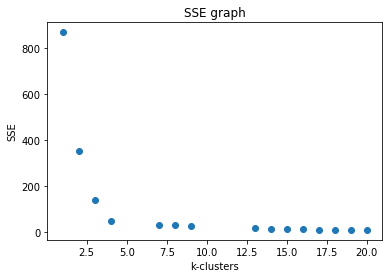

In [164]:
plt.scatter(k_list, SSE_list)
plt.xlabel("k-clusters")
plt.ylabel("SSE")
plt.title("SSE graph")

<h3>Wholesaler data </h3>

In [165]:
import pandas as pd

In [166]:
data = pd.read_csv('./Wholesale customers data.csv')
display(data.head())
display(data.shape)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


(440, 8)

In [167]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data.iloc[:, 2:])
data_pca = pca.transform(data.iloc[:, 2:])

display(pca.explained_variance_ratio_)
display(data_pca[:5])

array([0.45961362, 0.40517227])

array([[  650.02212207,  1585.51909007],
       [-4426.80497937,  4042.45150884],
       [-4841.9987068 ,  2578.762176  ],
       [  990.34643689, -6279.80599663],
       [10657.99873116, -2159.72581518]])

<h3>[Problem 10] Selection of the number of clusters k</h3>

In [152]:
SSE_list, k_list = elbow_method(
            X=data_pca,
            head_k=1,
            tail_k=50
            )
print("SSE_list: \n {}".format(SSE_list))
print("k_list: \n {}".format(k_list))

 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

KeyboardInterrupt: 

In [ ]:
plt.scatter(k_list, SSE_list)
plt.xlabel("k-clusters")
plt.ylabel("SSE")
plt.title("SSE graph")